In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rateModels3D as rm3D

In [2]:
def mstar_from_stellarprops(rstar, logg):
    """Gives stellar mass from the rstar and logg
       INPUT:
         rstar - Radius of star [Rsun]
         logg - log surface gravity [cgs]
       OUTPUT:
         mstar - stellar mass [Msun]
    """
    # Convert logg and rstar into stellar mass assuming logg_sun=4.437
    mstar = 10.0**logg * rstar**2. / 10.0**4.437
    return mstar


def transit_duration(rstar, logg, per, ecc=0):
    """Transit duration
       assuming uniform distribution of cos(inc) orbits,
       assuming rstar/a is small, and assuming rp/rstar is small.
       INPUT:
        rstar - Radius of star [Rsun]
        logg - log surface gravity [cgs]
        per - Period of orbit [day]
        ecc - Eccentricity; hardcoded to be < 0.99 
       OUTPUT:
        durat - Transit duration [hr]
       COMMENTS:  example:  x=transit_duration(1.0,4.437,365.25,0.0)
                            x=10.19559 [hr] duration for planet in 1 year orbit
                            around sun
    """
    # Replace large ecc values with 0.99
    ecc = np.where(ecc > 0.99, 0.99, ecc)
    # Convert logg and rstar into stellar mass
    mstar = mstar_from_stellarprops(rstar, logg)
    # Semi-major axis in AU
    semia = mstar**(1.0/3.0) * (per/365.25)**(2.0/3.0)
    # transit duration e=0 including pi/4 effect of cos(inc) dist
    r_sun = 6.9598e10 # cm
    au2cm = 1.49598e13 # 1 AU = 1.49598e13 cm
    durat = (per*24.0) / 4.0 * (rstar*r_sun) / (semia*au2cm)
    #transit duration e > 0
    durat = durat * np.sqrt(1.0-ecc**2);

    return durat

def earthflux_at_period(rstar, logg, teff, period):
    """Gives equivalent solar-earth bolometric flux for a given period
       INPUT:
         rstar - Radius of star [Rsun]
         logg - log surface gravity [cgs]
         teff - Effective Temperature [K]
         period - Orbital Period [day]
       OUTPUT:
         flx - Flux relative to sun-earth 
    """
    mstar = mstar_from_stellarprops(rstar, logg)
    # Calculate semi-major axis [AU]
    semia = mstar**(1.0/3.0) * (period/365.25)**(2.0/3.0)
    # Star bolometric luminosity in Lsun assuming teff_sun=5778.0
    lumstar = rstar**2.0 * (teff/5778.0)**4.0
    # Calculate solar earth bolometric flux ratio
    flx = lumstar / semia**2.0
    return flx

def period_at_earthflux(rstar, mstar, teff, seff):
    """Gives period for a given equivalent solar-earth bolometric flux
       INPUT:
         rstar - Radius of star [Rsun]
         mstar - stellar mass [Msun]
         teff - Effective Temperature [K]
         seff - insolation flux relative to sun-earth flux
       OUTPUT:
         period - Orbital period [days]
    """
    # Calculate semi-major axis [AU] assuming teff_sun=5778.0
    semia = rstar * (teff/5778.0)**2 / np.sqrt(seff)
    period = ( semia / (mstar**(1.0/3.0)) )**(3.0/2.0) * 365.25
    return period


def earthflux_at_semia(rstar, logg, teff, semia):
    """Gives equivalent solar-earth bolometric flux for a given period
       INPUT:
         rstar - Radius of star [Rsun]
         logg - log surface gravity [cgs]
         teff - Effective Temperature [K]
         semia - Orbital semi-major axis [AU]
       OUTPUT:
         flx - Flux relative to sun-earth 
    """
    mstar = mstar_from_stellarprops(rstar, logg)
    # Star bolometric luminosity in Lsun assuming teff_sun=5778.0
    lumstar = rstar**2.0 * (teff/5778.0)**4.0
    # Calculate solar earth bolometric flux ratio
    flx = lumstar / semia**2.0
    return flx

def semia_at_earthflux(rstar, teff, flx):
    """Gives equivalent solar-earth bolometric flux for a given period
       INPUT:
         rstar - Radius of star [Rsun]
         logg - log surface gravity [cgs]
         teff - Effective Temperature [K]
         flx - Flux relative to sun-earth
       OUTPUT:
         semia - Orbital semi-major axis [AU]
    """
    # Star bolometric luminosity in Lsun assuming teff_sun=5778.0
    lumstar = rstar**2.0 * (teff/5778.0)**4.0
    # Calculate solar earth bolometric flux ratio
    semia = np.sqrt(lumstar/flx)
    return semia


In [3]:
figDir = "summaryFigures"
stellarCatalog = "../stellarCatalogs/dr25_stellar_berger2020_clean_hab2.txt"
stellarTargets = pd.read_csv(stellarCatalog)
# allStars = pd.read_csv("../stellarCatalogs/dr25_stellar_supp_gaia_clean_GKM.txt")
print("stellarTargets has " + str(len(stellarTargets)) + " stars")


stellarTargets has 68885 stars


In [5]:
optHz = rm3D.getHzFlux(stellarTargets.iso_teff, hzType = "optimistic")


In [6]:
innerHzPeriod = period_at_earthflux(stellarTargets.iso_rad, stellarTargets.iso_mass, stellarTargets.iso_teff, optHz[0,:])
outerHzPeriod = period_at_earthflux(stellarTargets.iso_rad, stellarTargets.iso_mass, stellarTargets.iso_teff, optHz[1,:])

In [7]:
duration500d = transit_duration(stellarTargets.radius,stellarTargets.logg,500,0)
durationInnerHz = transit_duration(stellarTargets.radius,stellarTargets.logg,innerHzPeriod)
durationOuterHz = transit_duration(stellarTargets.radius,stellarTargets.logg,outerHzPeriod)

In [8]:
print(transit_duration(np.median(stellarTargets.radius),np.median(stellarTargets.logg),500,0))

11.122192613408783


In [9]:
np.max(durationOuterHz)

41.027300916459126

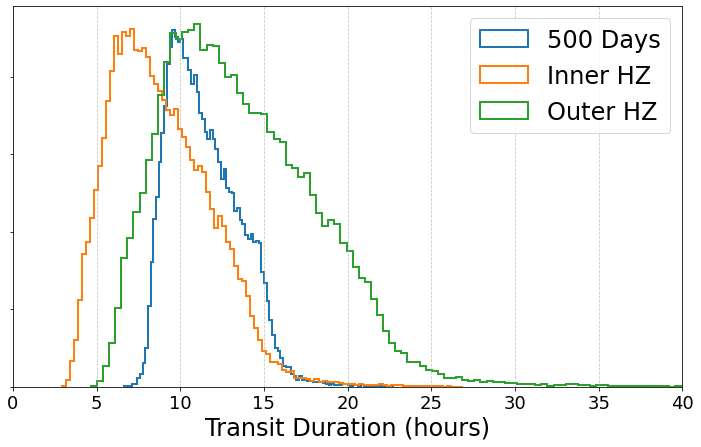

In [10]:
plt.figure(figsize=(12,7))
plt.hist(duration500d, 100, lw=2, histtype="step");
plt.hist(durationInnerHz, 100, lw=2, histtype="step");
plt.hist(durationOuterHz, 100, lw=2, histtype="step");
plt.legend(["500 Days", "Inner HZ", "Outer HZ"], fontsize = 24)
plt.xlim(0,40);
plt.tick_params(labelsize = 18)
plt.xlabel("Transit Duration (hours)", fontSize = 24);
plt.grid(axis='x', linestyle='--', alpha = 0.7)
plt.gca().set_yticklabels([])

plt.savefig("durationDist.pdf",bbox_inches='tight')


In [11]:
print("500 day fraction over 15 hours: " + str(np.sum(duration500d>15)/len(duration500d)))
print("Inner HZ fraction over 15 hours: " + str(np.sum(durationInnerHz>15)/len(durationInnerHz)))
print("Outer HZ fraction over 15 hours: " + str(np.sum(durationOuterHz>15)/len(durationOuterHz)))


500 day fraction over 15 hours: 0.056166073891268056
Inner HZ fraction over 15 hours: 0.02717572766204544
Outer HZ fraction over 15 hours: 0.3549539086883937


In [18]:
15/9*15

25.0

In [19]:
np.sum((durationOuterHz<25))/len(durationOuterHz)

0.9866734412426508

In [12]:
np.max(stellarTargets.radius)

2.27273921819

In [13]:
np.sum(stellarTargets.radius>1.35)

4670

In [14]:
np.sum(stellarTargets.radius>1.35)/float(len(stellarTargets))

0.06779414966973941

(array([   6.,   16.,   34.,  134.,  385.,  481.,  609.,  829.,  949.,
        1227.]),
 array([5555.26074847, 5629.73369038, 5704.20663229, 5778.6795742 ,
        5853.15251611, 5927.62545802, 6002.09839993, 6076.57134184,
        6151.04428375, 6225.51722566, 6299.99016757]),
 <a list of 10 Patch objects>)

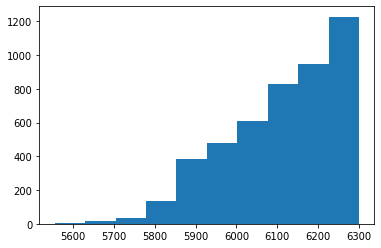

In [15]:
plt.hist(stellarTargets[stellarTargets.radius>1.35].iso_teff)